[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1zW_IcmclqmgacxpqdvXamv37fhElCTZJ?usp=sharing)

Source: https://github.com/ezponda/intro_deep_learning/blob/main/class/Fundamentals/Prevent_Overfitting.ipynb

# Prevent Overfitting: Regularization


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
tf.keras.utils.set_random_seed(0)

We will use the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), consisting of a collection of 28x28 pixel images corresponding in digits from 0 to 9 manuscripts. The purpose of this data set is to train models that recognize handwritten numbers.

We will train, therefore, an [OCR (Optical Character Recognition)](https://en.wikipedia.org/wiki/Optical_character_recognition) model for multiclass classification (numbers from 0 to 9).

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
x_train[0].shape

(28, 28)

As they are 8-bit images, the colors (in this case only one channel, the gray channel) of each pixel are encoded with a value between 0 and 255, with 0 being black and 255 being white. It is usual to normalize the values to work with a range between 0.0 and 1.0.

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

We visualize a random image of the training set.

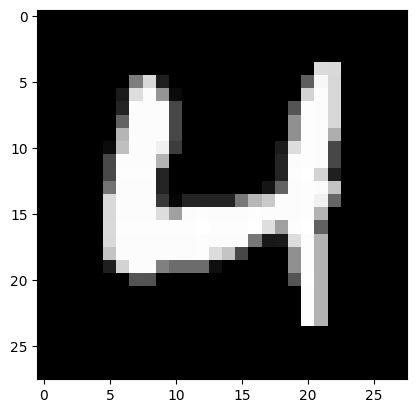

In [ ]:
import numpy as np

i = np.random.randint(0, len(x_train))
plt.imshow(x_train[i], cmap='gray')
plt.show()

We reduce the dataset for  inducing more overfitting

In [ ]:
from sklearn.model_selection import train_test_split
# split into train test sets
_, x, _, y = train_test_split(
    x_train, y_train, test_size=0.02, random_state=1, stratify=y_train)

num_classes = 10
from collections import Counter
x.shape, y.shape, Counter(y)

((1200, 28, 28),
 (1200,),
 Counter({2: 119,
          8: 117,
          6: 118,
          9: 119,
          3: 123,
          4: 117,
          0: 119,
          7: 125,
          5: 108,
          1: 135}))

#### Why do we need to use regularization?

We are going to assign the classes randomly to each image with random shuffle.

In [ ]:
y_shuffle = np.copy(y)
np.random.shuffle(y_shuffle)
y[:5], y_shuffle[:5]

(array([2, 8, 6, 9, 3], dtype=uint8), array([3, 9, 4, 3, 0], dtype=uint8))

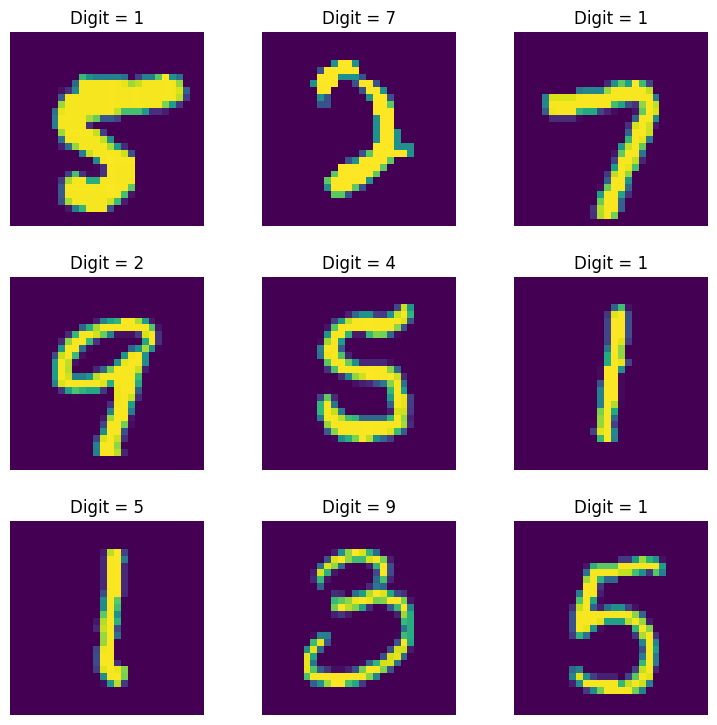

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.ravel()

for i in np.arange(0, 9):
    ind = np.random.randint(len(y_shuffle))
    axes[i].imshow(x[ind].reshape(28, 28))
    axes[i].set_title(
        f"Digit = {y_shuffle[ind]}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.3)

Lets build a model for learning the new random classes

In [ ]:
# Input
inputs = tf.keras.Input(shape=(28, 28))
# Convert the 2D image to a vector
flat = layers.Flatten()(inputs)

# hidden layer 1
l_1 = layers.Dense(64, activation='relu')(flat)
# hidden layer 2
l_2 = layers.Dense(64, activation='relu')(l_1)
# hidden layer 3
l_3 = layers.Dense(64, activation='relu')(l_2)

# Outputs
outputs = layers.Dense(10, activation='softmax')(l_3)

# Model definition
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(
    x,
    y_shuffle,
    batch_size=64,
    epochs=100,
    shuffle=True
)

Epoch 1/100
19/19 [==============================] - 6s 4ms/step - loss: 2.3156 - accuracy: 0.0967
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 2.2819 - accuracy: 0.1425
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 2.2500 - accuracy: 0.1750
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 2.2070 - accuracy: 0.2342
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 2.1541 - accuracy: 0.2483
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 2.0932 - accuracy: 0.2750
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 2.0258 - accuracy: 0.3042
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 1.9561 - accuracy: 0.3325
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 1.8625 - accuracy: 0.3683
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 1.7714 - accuracy: 0.4125
Epoch 11/

In [ ]:
results = model.evaluate(x, y_shuffle, verbose=0)
print('Train Accuracy: {}'.format(results[1]))

Train Accuracy: 1.0


1/1 [==============================] - 0s 19ms/step


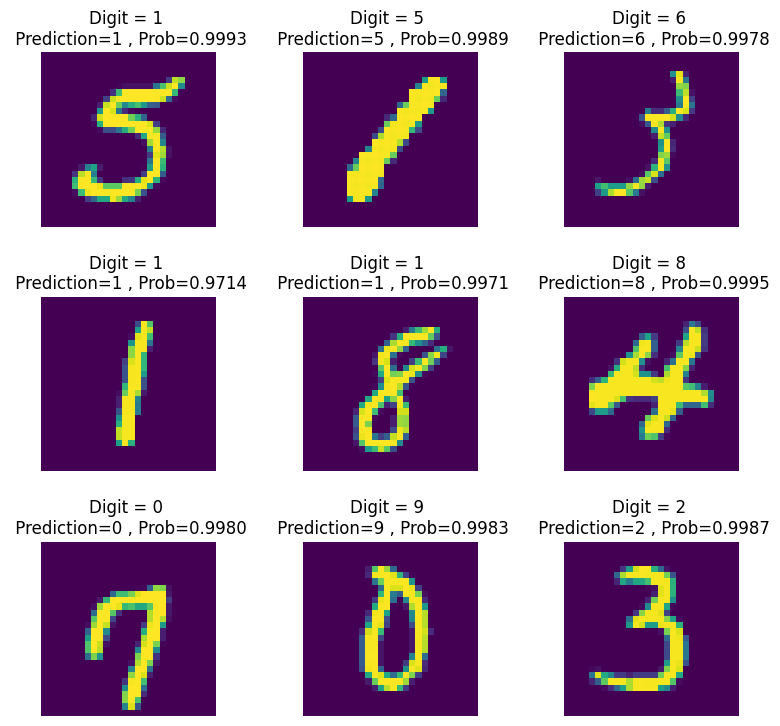

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.ravel()

for i in np.arange(0, 9):
    ind = np.random.randint(len(y_shuffle))
    pred_pobs = model.predict(np.expand_dims(x[ind], 0)).flatten()
    pred_class = np.argmax(pred_pobs)
    prob = np.max(pred_pobs)
    axes[i].imshow(x[ind].reshape(28, 28))
    axes[i].set_title(
        f"Digit = {y_shuffle[ind]} \n Prediction={pred_class} , Prob={prob:.4f}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

We can see that the model has fully fitted the training set. It practically does not matter what data you introduce into the neural network, it will almost always fit. The objective is not to fit the training set, it is to **GENERALIZE**.

#### Regularization for preventing overfitting

To get the model to **generalize**, we can use one of the numerous regularization techniques

We build a model consisting of:

- Input with dimension (28,28)
- Flatten layer
- Dense hidden  layer with 256 neurons and ReLU as activation function
- Second dense hidden layer with 128 neurons and ReLU as activation function
- Third dense  hidden layer with 128 neurons and ReLU as activation function
- Output layer with a single neuron that implements the sigmoid function.

In [ ]:
# Input
inputs = tf.keras.Input(shape=(28,28), name='input_layer')
# Convert the 2D image to a vector
flat = layers.Flatten()(inputs)

# hidden layer 1
l_1 = layers.Dense(256, activation='relu', name='layer_1')(flat)
# hidden layer 2
l_2 = layers.Dense(128, activation='relu', name='layer_2')(l_1)
# hidden layer 3
l_3 = layers.Dense(128, activation='relu', name='layer_3')(l_2)

# Outputs
outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(l_3)

# Model definition
model = keras.Model(inputs=inputs, outputs=outputs, name='dont_overfit_model')

In [ ]:
model.summary()

Model: "dont_overfit_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28)]          0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 layer_1 (Dense)             (None, 256)               200960    
                                                                 
 layer_2 (Dense)             (None, 128)               32896     
                                                                 
 layer_3 (Dense)             (None, 128)               16512     
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 251658 (983.04 KB)
Trainable param

We define the following configuration for training:
- **optimizer**: adam
- **loss function**: binary crossentropy
- **metrics**: accuracy

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    x,
    y,
    batch_size=64,
    epochs=100,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/100
15/15 [==============================] - 2s 33ms/step - loss: 1.7887 - accuracy: 0.4708 - val_loss: 1.0166 - val_accuracy: 0.7917
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 0.6667 - accuracy: 0.8302 - val_loss: 0.4488 - val_accuracy: 0.8542
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 0.3531 - accuracy: 0.8865 - val_loss: 0.4575 - val_accuracy: 0.8708
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.2204 - accuracy: 0.9302 - val_loss: 0.3976 - val_accuracy: 0.8875
Epoch 5/100
15/15 [==============================] - 0s 5ms/step - loss: 0.1273 - accuracy: 0.9698 - val_loss: 0.3437 - val_accuracy: 0.9042
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0856 - accuracy: 0.9875 - val_loss: 0.3597 - val_accuracy: 0.9000
Epoch 7/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0568 - accuracy: 0.9927 - val_loss: 0.3385 - val_accuracy: 0.8958
Epoch 8/100


In [ ]:
results = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.5553760528564453
Test Accuracy: 0.9079999923706055


We visualize the evolution of the values in each epoch of the loss function and accuracy.

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [ ]:
hist.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,1.788694,0.470833,1.016618,0.791667,0
1,0.666682,0.830208,0.448835,0.854167,1
2,0.353123,0.886458,0.457514,0.870833,2
3,0.220378,0.930208,0.397566,0.887500,3
4,0.127266,0.969792,0.343674,0.904167,4


<a id='overfitting_results'></a>
When interpreting both graphs, it is evident that the model over-fits the training values and is not able to generalize well for the validation values. **It is a clear example of overfitting**.

The following function will be useful throughout the different practical examples.

In [ ]:
import matplotlib.pyplot as plt

def show_loss_accuracy_evolution(history):

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

def show_samples(x_test, y_test, model):
    predictions = model.predict(x_test)
    predicted_classes = np.argmax(predictions, -1)

    L = 5
    W = 5
    fig, axes = plt.subplots(L, W, figsize=(14, 14))
    axes = axes.ravel()

    for i in np.arange(0, L * W):
        ind = np.random.randint(len(y_test))
        axes[i].imshow(x_test[ind].reshape(28, 28))
        prob_pred = np.max(predictions[ind, :])
        class_pred = int(predicted_classes[ind])
        original_class = int(y_test[ind])
        if class_pred == original_class:
            color = 'green'
        else:
            color = 'red'
        title = "Pred: {0} \n Target: {1} \n Prob: {2:.3f}".format(
        class_pred, original_class, prob_pred)
        axes[i].set_title(title, color=color)
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)

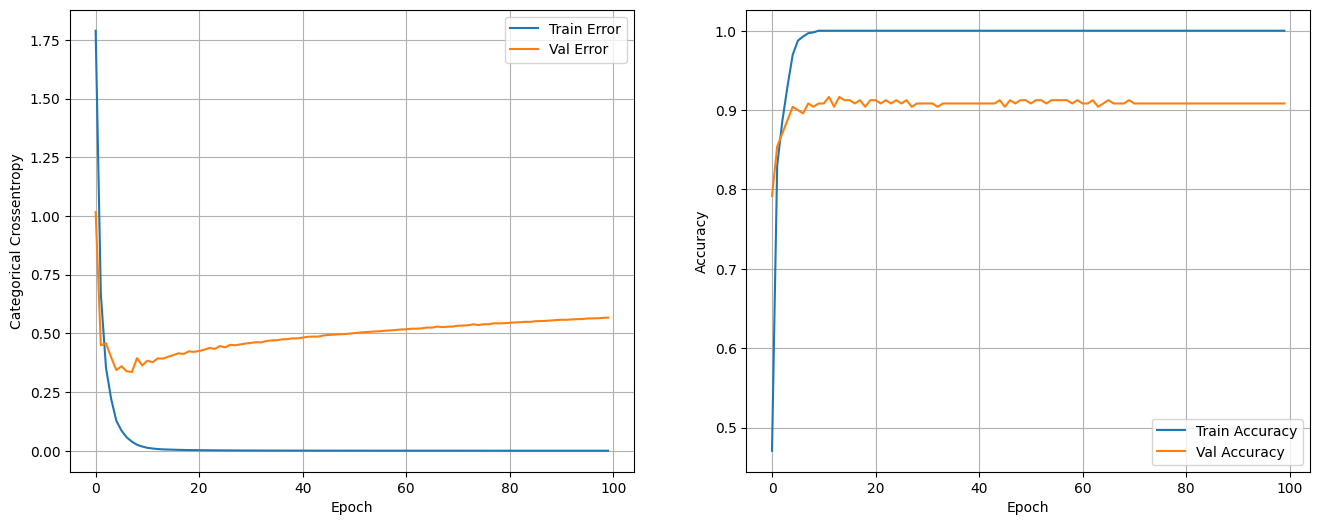

In [ ]:
show_loss_accuracy_evolution(history)

In [ ]:
results = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.5553760528564453
Test Accuracy: 0.9079999923706055


313/313 [==============================] - 1s 2ms/step


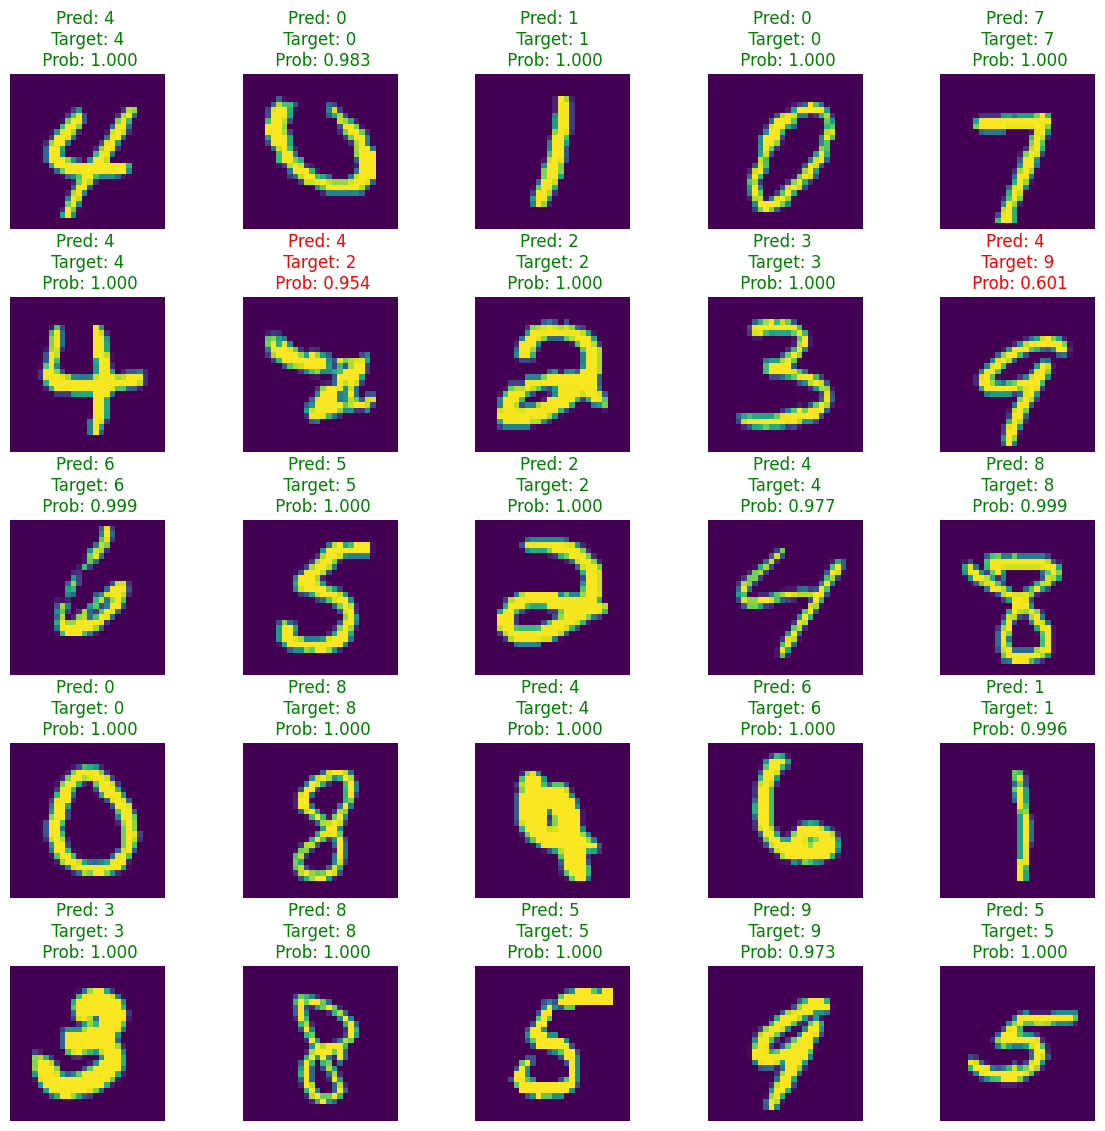

In [ ]:
show_samples(x_test, y_test, model)

## Create a simpler model

The simplest way to prevent overfitting is to create  a simple model: A model with less number of  parameters (which is determined by the number of layers and the number of units per layer).

A more complex model with more parameters will have much more capacity and will be able to learn almost any training set. Deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

In [ ]:
# Input layer
inputs = tf.keras.Input(shape=(28, 28), name='input_layer')
flat = layers.Flatten()(inputs)

# First hidden layer
l_1 = layers.Dense(8, activation='relu', name='layer_1')(flat)

# Output layer
outputs = layers.Dense(num_classes, activation='softmax',
                       name='output_layer')(l_1)
model_simpler = keras.Model(
    inputs=inputs, outputs=outputs, name='simpler_model')

model_simpler.summary()

Model: "simpler_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28)]          0         
                                                                 
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 layer_1 (Dense)             (None, 8)                 6280      
                                                                 
 output_layer (Dense)        (None, 10)                90        
                                                                 
Total params: 6370 (24.88 KB)
Trainable params: 6370 (24.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_simpler.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
history_simpler = model_simpler.fit(x,
                                    y,
                                    batch_size=64,
                                    epochs=100,
                                    validation_split=0.25,
                                    shuffle=True)

Epoch 1/100
15/15 [==============================] - 1s 14ms/step - loss: 2.2910 - accuracy: 0.1411 - val_loss: 2.2395 - val_accuracy: 0.1500
Epoch 2/100
15/15 [==============================] - 0s 6ms/step - loss: 2.1538 - accuracy: 0.2167 - val_loss: 2.0945 - val_accuracy: 0.2667
Epoch 3/100
15/15 [==============================] - 0s 6ms/step - loss: 2.0028 - accuracy: 0.3289 - val_loss: 1.9450 - val_accuracy: 0.3400
Epoch 4/100
15/15 [==============================] - 0s 6ms/step - loss: 1.8518 - accuracy: 0.3989 - val_loss: 1.8185 - val_accuracy: 0.3933
Epoch 5/100
15/15 [==============================] - 0s 5ms/step - loss: 1.7352 - accuracy: 0.4411 - val_loss: 1.7181 - val_accuracy: 0.4467
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 1.6289 - accuracy: 0.5200 - val_loss: 1.6182 - val_accuracy: 0.5367
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 1.5276 - accuracy: 0.5711 - val_loss: 1.5266 - val_accuracy: 0.5800
Epoch 8/100


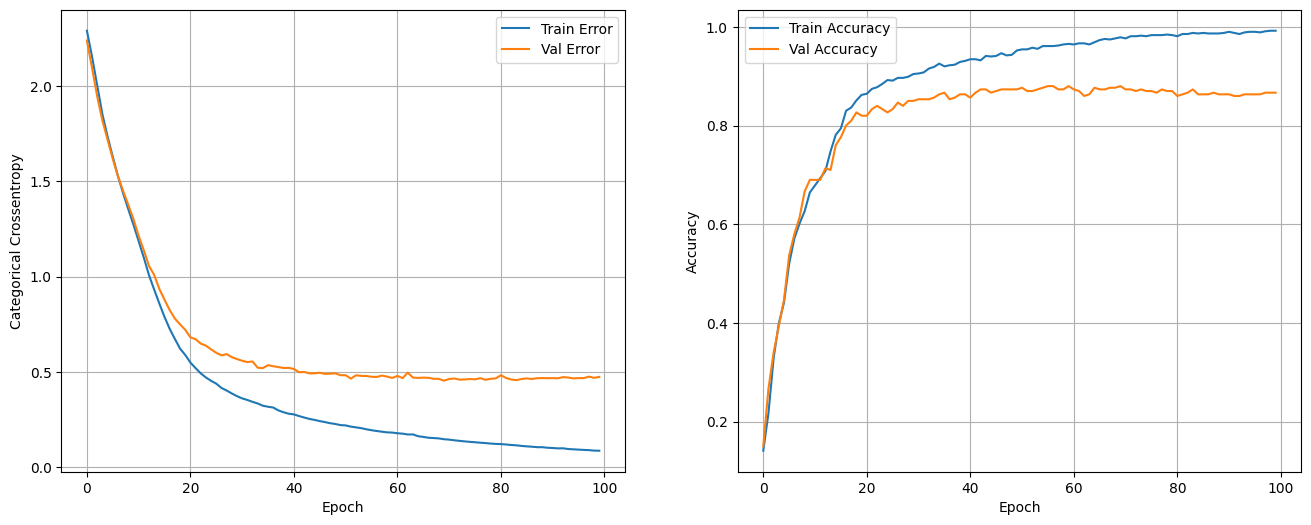

In [ ]:
show_loss_accuracy_evolution(history_simpler)

In [ ]:
results = model_simpler.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.5051917433738708
Test Accuracy: 0.8582000136375427


## Reduce batch_size

Other method is decreasing the `batch_size`during the gradient descend to add more uncertainty to the estimation of the parameter gradients, thus reducing the capacity of the model

In [ ]:
# Input
inputs = tf.keras.Input(shape=(28,28), name='input_layer')
# Convert the 2D image to a vector
flat = layers.Flatten()(inputs)

# hidden layer 1
l_1 = layers.Dense(256, activation='relu', name='layer_1')(flat)
# hidden layer 2
l_2 = layers.Dense(128, activation='relu', name='layer_2')(l_1)
# hidden layer 3
l_3 = layers.Dense(128, activation='relu', name='layer_3')(l_2)

# Outputs
outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(l_3)

# Model definition
model = keras.Model(inputs=inputs, outputs=outputs, name='dont_overfit_model')
## same model
model.summary()

Model: "dont_overfit_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28)]          0         
                                                                 
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 layer_1 (Dense)             (None, 256)               200960    
                                                                 
 layer_2 (Dense)             (None, 128)               32896     
                                                                 
 layer_3 (Dense)             (None, 128)               16512     
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 251658 (983.04 KB)
Trainable param

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history_2 = model.fit(
    x,
    y,
    batch_size=16,
    epochs=100,
    validation_split=0.2,
    shuffle=True
)


Epoch 1/100
60/60 [==============================] - 2s 6ms/step - loss: 1.2286 - accuracy: 0.6469 - val_loss: 0.5138 - val_accuracy: 0.8375
Epoch 2/100
60/60 [==============================] - 0s 4ms/step - loss: 0.3459 - accuracy: 0.8875 - val_loss: 0.4469 - val_accuracy: 0.8625
Epoch 3/100
60/60 [==============================] - 0s 4ms/step - loss: 0.2340 - accuracy: 0.9302 - val_loss: 0.3761 - val_accuracy: 0.8917
Epoch 4/100
60/60 [==============================] - 0s 4ms/step - loss: 0.1145 - accuracy: 0.9698 - val_loss: 0.4390 - val_accuracy: 0.8625
Epoch 5/100
60/60 [==============================] - 0s 4ms/step - loss: 0.0912 - accuracy: 0.9760 - val_loss: 0.3431 - val_accuracy: 0.9042
Epoch 6/100
60/60 [==============================] - 0s 5ms/step - loss: 0.0307 - accuracy: 0.9948 - val_loss: 0.3700 - val_accuracy: 0.9083
Epoch 7/100
60/60 [==============================] - 0s 4ms/step - loss: 0.0161 - accuracy: 0.9990 - val_loss: 0.3714 - val_accuracy: 0.9083
Epoch 8/100
6

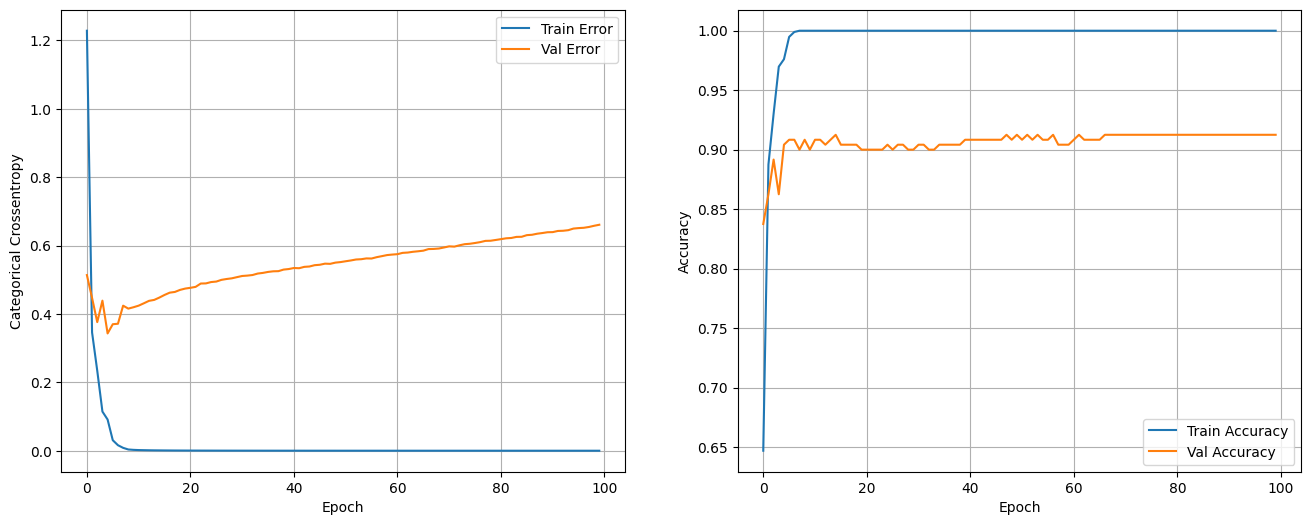

In [ ]:
show_loss_accuracy_evolution(history_2)

In [ ]:
results = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.6229918003082275
Test Accuracy: 0.9096999764442444


### Question 1:
#### What differences do you see if you change the batch_size to a lower or higher value? For example to 1 and to 512

<a id='dropout'></a>
## Dropout

Dropout, applied to a layer, consists of randomly "dropping out" (set to zero) a number of output features of the layer during training with a probability **p** (`dropout rate`).

In `keras` you can introduce dropout in a network via the [Dropout layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout), which gets applied to the output of layer right before.

```python
tf.keras.layers.Dropout(
    rate, noise_shape=None, seed=None, **kwargs
)
```

With Functional API:
```python
next_layer = layers.Dropout(0.4)(prev_layer)
```
With Sequential:
```python
model.add(layers.Dropout(0.4))
```

In [ ]:
# Input
inputs = tf.keras.Input(shape=(28, 28), name='input_layer')
# Convert the 2D image to a vector
flat = layers.Flatten()(inputs)

flat = layers.Dropout(0.5, name='dropout_flat')(flat)
# hidden layer 1
l_1 = layers.Dense(256, activation='relu', name='layer_1')(flat)
l_1 = layers.Dropout(0.5, name='dropout_l1')(l_1)
# hidden layer 2
l_2 = layers.Dense(128, activation='relu', name='layer_2')(l_1)
l_2 = layers.Dropout(0.5, name='dropout_l2')(l_2)
# hidden layer 3
l_3 = layers.Dense(128, activation='relu', name='layer_3')(l_2)
l_3 = layers.Dropout(0.5, name='dropout_l3')(l_3)

# Outputs
outputs = layers.Dense(num_classes, activation='softmax',
                       name='output_layer')(l_3)


model_dropout = keras.Model(
    inputs=inputs, outputs=outputs, name='dont_overfit_model_dropout')

In [ ]:
model_dropout.summary()

Model: "dont_overfit_model_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28)]          0         
                                                                 
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dropout_flat (Dropout)      (None, 784)               0         
                                                                 
 layer_1 (Dense)             (None, 256)               200960    
                                                                 
 dropout_l1 (Dropout)        (None, 256)               0         
                                                                 
 layer_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_l2 (Dropout)        (None, 128)

In [ ]:
model_dropout.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [ ]:
history_dropout = model_dropout.fit(
    x,
    y,
    batch_size=64,
    epochs=100,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/100
15/15 [==============================] - 3s 24ms/step - loss: 2.4881 - accuracy: 0.1063 - val_loss: 2.2461 - val_accuracy: 0.2792
Epoch 2/100
15/15 [==============================] - 0s 8ms/step - loss: 2.3052 - accuracy: 0.1427 - val_loss: 2.1995 - val_accuracy: 0.4250
Epoch 3/100
15/15 [==============================] - 0s 7ms/step - loss: 2.2202 - accuracy: 0.1833 - val_loss: 2.1208 - val_accuracy: 0.5000
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 2.1133 - accuracy: 0.2365 - val_loss: 1.9765 - val_accuracy: 0.5625
Epoch 5/100
15/15 [==============================] - 0s 6ms/step - loss: 2.0430 - accuracy: 0.2562 - val_loss: 1.7701 - val_accuracy: 0.6375
Epoch 6/100
15/15 [==============================] - 0s 6ms/step - loss: 1.9144 - accuracy: 0.3187 - val_loss: 1.5173 - val_accuracy: 0.6708
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 1.7225 - accuracy: 0.4208 - val_loss: 1.2588 - val_accuracy: 0.7292
Epoch 8/100


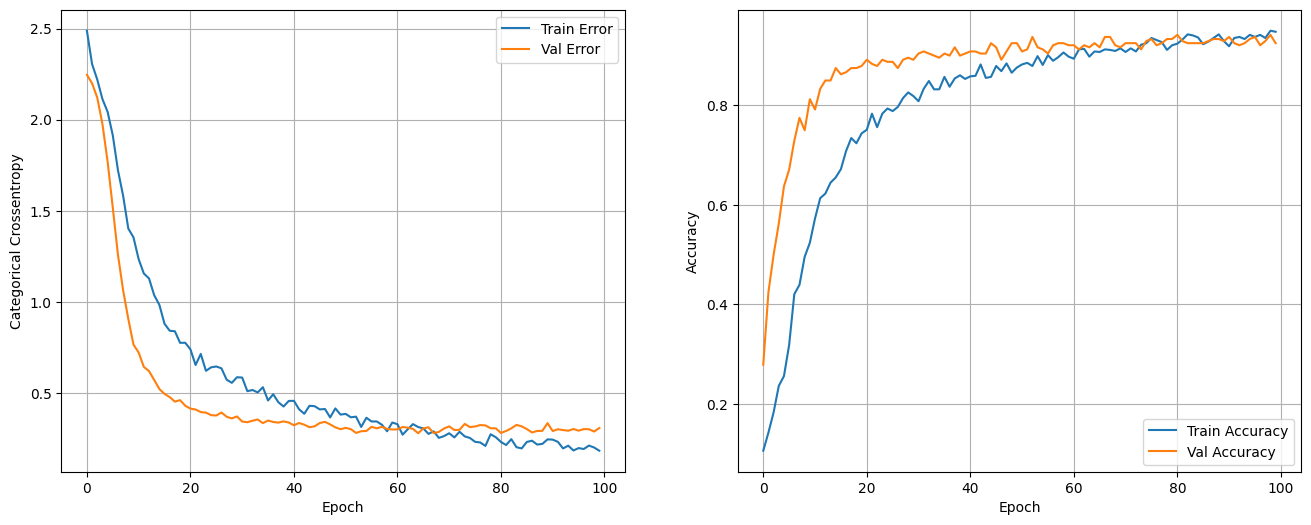

In [ ]:
show_loss_accuracy_evolution(history_dropout)

In [ ]:
results = model_dropout.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.3209829032421112
Test Accuracy: 0.9212999939918518


### Question 2:
#### What happens if you change the dropout to 0.1 or 0.9? And what if you put it only on one layer?
#### What happens if we delete the flatten first dropout?

## Batch Normalization

[Batch normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.


With Functional API:
```python
next_layer = layers.BatchNormalization()(prev_layer)
```
With Sequential:
```python
model.add(layers.BatchNormalization())
```

In [ ]:
# Input
inputs = tf.keras.Input(shape=(28, 28), name='input_layer')
# Convert the 2D image to a vector
flat = layers.Flatten()(inputs)

# hidden layer 1
l_1 = layers.Dense(256, activation='relu', name='layer_1')(flat)
l_1 = layers.BatchNormalization()(l_1)
# hidden layer 2
l_2 = layers.Dense(128, activation='relu', name='layer_2')(l_1)
l_2 = layers.BatchNormalization()(l_2)
# hidden layer 3
l_3 = layers.Dense(128, activation='relu', name='layer_3')(l_2)

# Outputs
outputs = layers.Dense(num_classes, activation='softmax',
                       name='output_layer')(l_3)




model_batch_norm = keras.Model(inputs=inputs, outputs=outputs, name='dont_overfit_model_batch_norm')

In [ ]:
model_batch_norm.summary()

Model: "dont_overfit_model_batch_norm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28)]          0         
                                                                 
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 layer_1 (Dense)             (None, 256)               200960    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 layer_2 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                    

In [ ]:
model_batch_norm.compile(
    optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_batch_norm = model_batch_norm.fit(
    x,
    y,
    batch_size=64,
    epochs=100,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/100
15/15 [==============================] - 3s 20ms/step - loss: 1.4054 - accuracy: 0.5552 - val_loss: 1.7604 - val_accuracy: 0.6792
Epoch 2/100
15/15 [==============================] - 0s 6ms/step - loss: 0.3941 - accuracy: 0.9146 - val_loss: 1.4560 - val_accuracy: 0.7833
Epoch 3/100
15/15 [==============================] - 0s 6ms/step - loss: 0.1836 - accuracy: 0.9708 - val_loss: 1.2032 - val_accuracy: 0.8958
Epoch 4/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0874 - accuracy: 0.9958 - val_loss: 1.0342 - val_accuracy: 0.8958
Epoch 5/100
15/15 [==============================] - 0s 7ms/step - loss: 0.0504 - accuracy: 0.9948 - val_loss: 0.8971 - val_accuracy: 0.9083
Epoch 6/100
15/15 [==============================] - 0s 7ms/step - loss: 0.0304 - accuracy: 0.9990 - val_loss: 0.7896 - val_accuracy: 0.9042
Epoch 7/100
15/15 [==============================] - 0s 7ms/step - loss: 0.0204 - accuracy: 1.0000 - val_loss: 0.6848 - val_accuracy: 0.9083
Epoch 8/100


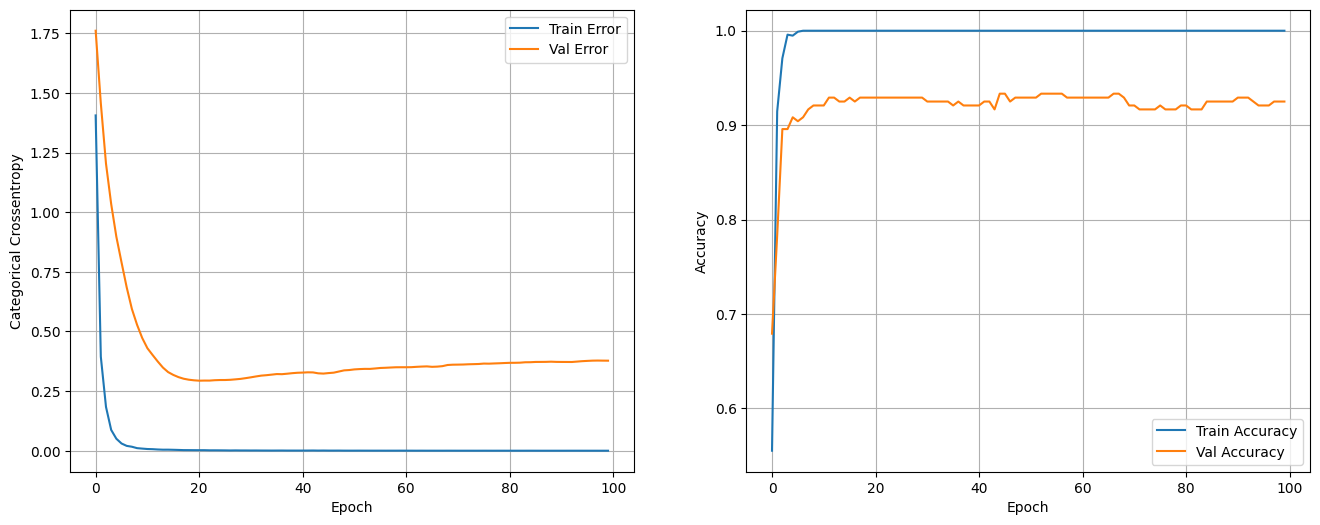

In [ ]:
show_loss_accuracy_evolution(history_batch_norm)

In [ ]:
results = model_batch_norm.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.3952188491821289
Test Accuracy: 0.9103999733924866


<a id='l1_l2_elasticnet'></a>
## L1, L2 and ElasticNet

Recordemos que durante el entrenamiento de la red se aprende la configuración de pesos y biases que permita mejorar los resultados para una determinada función de pérdida.

* [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the cost added is proportional to the absolute value of the weights coefficients ("L1 norm" of the weights).

```python
tf.keras.regularizers.l1(l1=0.01)

layers.Dense(3, kernel_regularizer='l1')

```


* [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the cost added is proportional to the square of the value of the weights coefficients ( "L2 norm" of the weights).

```python
tf.keras.regularizers.l2(l2=0.01)

layers.Dense(3, kernel_regularizer='l2')

```
* L1_L2 or Elastic Net.

```python
tf.keras.regularizers.l1_l2(
    l1=0.01, l2=0.01
)

layers.Dense(3, kernel_regularizer='l1_l2')

```

Furthermore, it is possible to choose whether to include the penalty in the cost function on the weights, the biases or on the activation, with the following arguments:
- `kernel_regularizer`: only on weights.
- `bias_regularizer`: only on biases.
- `activity_regularizer`: on full output.

[link to documentation](https://keras.io/api/layers/regularizers/).

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
kerner_regularizer_l1 = regularizers.l1_l2(l1=1e-5, l2=5e-4)
kerner_regularizer_l2 = regularizers.l2(5e-4)
kerner_regularizer_l3 = regularizers.l1(1e-5)

In [ ]:

# Input
inputs = tf.keras.Input(shape=(28, 28), name='input_layer')
# Convert the 2D image to a vector
flat = layers.Flatten()(inputs)

# hidden layer 1
l_1 = layers.Dense(256, activation='relu',
                   kernel_regularizer=kerner_regularizer_l1, name='layer_1')(flat)
# hidden layer 2
l_2 = layers.Dense(128, activation='relu',
                   kernel_regularizer=kerner_regularizer_l2, name='layer_2')(l_1)
# hidden layer 3
l_3 = layers.Dense(128, activation='relu',
                   kernel_regularizer=kerner_regularizer_l3, name='layer_3')(l_2)

# Outputs
outputs = layers.Dense(num_classes, activation='softmax',
                       name='output_layer')(l_3)


model_regularizers = keras.Model(inputs=inputs,
                                 outputs=outputs,
                                 name='dont_overfit_model_regularizers')

In [ ]:
model_regularizers.summary()

Model: "dont_overfit_model_regularizers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28)]          0         
                                                                 
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 layer_1 (Dense)             (None, 256)               200960    
                                                                 
 layer_2 (Dense)             (None, 128)               32896     
                                                                 
 layer_3 (Dense)             (None, 128)               16512     
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 251658 (983.04 KB)
Tr

In [ ]:
model_regularizers.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_regularizers = model_regularizers.fit(
    x,
    y,
    batch_size=64,
    epochs=100,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/100
15/15 [==============================] - 2s 18ms/step - loss: 2.1706 - accuracy: 0.4969 - val_loss: 1.4431 - val_accuracy: 0.7667
Epoch 2/100
15/15 [==============================] - 0s 6ms/step - loss: 1.0265 - accuracy: 0.8135 - val_loss: 0.7908 - val_accuracy: 0.8500
Epoch 3/100
15/15 [==============================] - 0s 7ms/step - loss: 0.6721 - accuracy: 0.8802 - val_loss: 0.6911 - val_accuracy: 0.8792
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4960 - accuracy: 0.9385 - val_loss: 0.6373 - val_accuracy: 0.8875
Epoch 5/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4146 - accuracy: 0.9594 - val_loss: 0.5872 - val_accuracy: 0.9042
Epoch 6/100
15/15 [==============================] - 0s 6ms/step - loss: 0.3659 - accuracy: 0.9781 - val_loss: 0.6090 - val_accuracy: 0.8958
Epoch 7/100
15/15 [==============================] - 0s 6ms/step - loss: 0.3249 - accuracy: 0.9885 - val_loss: 0.5741 - val_accuracy: 0.9083
Epoch 8/100


Lets compare the weights norms of the model without regularization and with regularization.

In [ ]:
for ly in model.layers:
    if 'layer_' in ly.name:
        W, b = ly.get_weights()
        l2_norm = np.sum(W**2)**0.5
        zero_elems = len(W[np.abs(W) < 1e-14])
        sparsity = zero_elems / np.prod(W.shape)
        sparsity = np.round(100 * sparsity, 2)
        print('L2 norm {0} weights: {1}, shape:{2}, sparsity:{3}'.format(
            ly.name, l2_norm, W.shape,sparsity))

L2 norm layer_1 weights: 22.35462748777504, shape:(784, 256), sparsity:0.0
L2 norm layer_2 weights: 14.847956846306014, shape:(256, 128), sparsity:0.0
L2 norm layer_3 weights: 12.514636816286547, shape:(128, 128), sparsity:0.0


In [ ]:
for ly in model_regularizers.layers:
    if 'layer_' in ly.name:
        W, b = ly.get_weights()
        l2_norm = np.sum(W**2)**0.5
        zero_elems = len(W[np.abs(W) < 1e-14])
        sparsity = zero_elems / np.prod(W.shape)
        sparsity = np.round(100 * sparsity, 2)
        print('L2 norm {0} weights: {1}, shape:{2}, sparsity:{3}'.format(
            ly.name, l2_norm, W.shape,sparsity))

L2 norm layer_1 weights: 5.515832826843254, shape:(784, 256), sparsity:0.0
L2 norm layer_2 weights: 6.229506195239189, shape:(256, 128), sparsity:8.58
L2 norm layer_3 weights: 11.263912837991734, shape:(128, 128), sparsity:0.0


In [ ]:
for ly in model_batch_norm.layers:
    if 'layer_' in ly.name:
        W, b = ly.get_weights()
        l2_norm = np.sum(W**2)**0.5
        zero_elems = len(W[np.abs(W) < 1e-14])
        sparsity = zero_elems / np.prod(W.shape)
        sparsity = np.round(100 * sparsity, 2)
        print('L2 norm {0} weights: {1}, shape:{2}, sparsity:{3}'.format(
            ly.name, l2_norm, W.shape,sparsity))

L2 norm layer_1 weights: 20.001322893260554, shape:(784, 256), sparsity:0.0
L2 norm layer_2 weights: 13.112509751657182, shape:(256, 128), sparsity:0.0
L2 norm layer_3 weights: 12.335154493436761, shape:(128, 128), sparsity:0.0


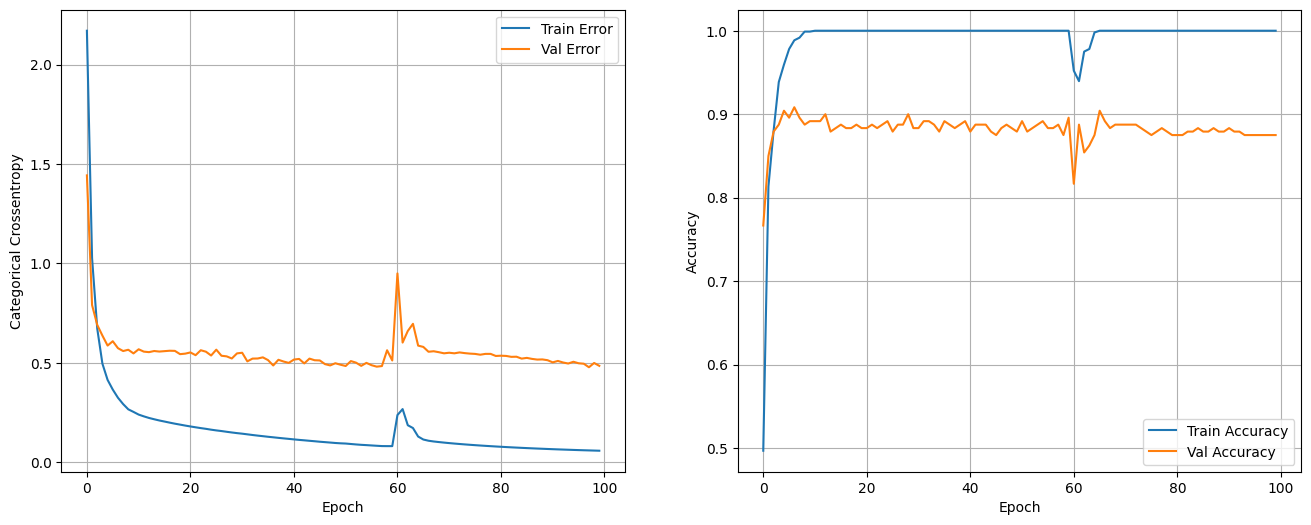

In [ ]:
show_loss_accuracy_evolution(history_regularizers)

In [ ]:
results = model_regularizers.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.488131582736969
Test Accuracy: 0.9004999995231628


### Question 3:
#### What happens if you change the regularizers?


## Combine L2 Regularization and Dropout

Use L2:
```python
kerner_regularizer_l2 = regularizers.l2(5e-4)
```
And Dropout:

```python
next_layer = layers.Dropout(0.4)(prev_layer)
```

In [ ]:
kerner_regularizer_l2 = ...

In [ ]:
inputs = tf.keras.Input(shape=(..., ), name='input_layer')

# Convert the 2D image to a vector
flat = layers....()(inputs)


# Add L2-normalization
l_1 = layers.Dense(128, activation='relu',
                   kernel_regularizer=...,
                   name='layer_1')(flat)

# Add dropout
l_1 = ...(l_1)


# Add L2-normalization
l_2 = layers.Dense(64,
                   activation='relu',
                   kernel_regularizer=...,
                   name='layer_2')(l_1)
# Add dropout
l_2 = ...(l_2)


# Add L2-normalization
l_3 = layers.Dense(32,
                   activation='relu',
                   kernel_regularizer=...,
                   name='layer_3')(l_2)

# Add dropout
l_3 = ...(l_3)


outputs = layers.Dense(..., activation=...,
                       name='output_layer')(l_3)

model_combination = keras.Model(inputs=inputs,
                                 outputs=outputs,
                                 name='dont_overfit_model_regularizers')

SyntaxError: ignored

In [ ]:
model_combination.compile(
    optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']
)

In [ ]:
history_combination = model_combination.fit(
    x,
    y,
    batch_size=64,
    epochs=100,
    validation_split=0.2,
    shuffle=True
)

In [ ]:
show_loss_accuracy_evolution(history_combination)

In [ ]:
results = model_combination.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

## Noise injection

Apply additive zero-mean Gaussian noise.

With Functional API:
```python
next_layer = layers.GaussianNoise(stddev)(prev_layer)
```
With Sequential:
```python
model.add(layers.GaussianNoise(stddev)())
```

In [ ]:
stddev = 2

# Input
inputs = tf.keras.Input(shape=(28,28), name='input_layer')
# Convert the 2D image to a vector
flat = layers.Flatten()(inputs)

# hidden layer 1
l_1 = layers.Dense(256, activation='relu', name='layer_1')(flat)
l_1 = layers.GaussianNoise(stddev, name='noise_l1')(l_1)
# hidden layer 2
l_2 = layers.Dense(128, activation='relu', name='layer_2')(l_1)
l_2 = layers.GaussianNoise(stddev, name='noise_l2')(l_2)
# hidden layer 3
l_3 = layers.Dense(128, activation='relu', name='layer_3')(l_2)
l_3 = layers.GaussianNoise(stddev, name='noise_l3')(l_3)

# Outputs
outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(l_3)

model_noise = keras.Model(inputs=inputs, outputs=outputs, name='dont_overfit_model_noise')

In [ ]:
model_noise.summary()

In [ ]:
model_noise.compile(
    optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_noise = model_noise.fit(
    x,
    y,
    batch_size=64,
    epochs=100,
    validation_split=0.2,
    shuffle=True
)

In [ ]:
show_loss_accuracy_evolution(history_noise)

In [ ]:
results = model_noise.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

<a id='early_stopping'></a>
## Early Stopping

Another of the most used techniques in neural network training is **early stopping**. It basically consists of stopping the training process in an Epoch prior to the one defined in the compilation.

This, in addition to resulting in a model with less overfitting, saves unnecessary computation time.

To do this, we can use the [Keras callbacks](https://keras.io/api/callbacks/), objects that perform actions at different times during training. Specifically, we will make use of [`EarlyStopping`](https://keras.io/api/callbacks/early_stopping/).

```python
tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    restore_best_weights=False,
    verbose=0,
)
```

- **monitor**: Quantity to be monitored. Depending on the evolution, it will be decided to stop training.

- **min_delta**: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.

- **patience**: Number of epochs with no improvement after which training will be stopped.

- **restor_best_weights**: Whether to restore model weights from the epoch with the best value of the monitored quantity

- **verbose**: verbosity mode.

There are other callbacks that can be very useful such as:
- [`ModelCheckpoint`](https://keras.io/api/callbacks/model_checkpoint/), which allows storing the state of a model at different times of training. This is very useful in trainings that can take hours or days.
- [`TensorBoard`](https://keras.io/api/callbacks/tensorboard/), which allows the use of [TensorBoard](https://www.tensorflow.org/tensorboard?hl=es-419), framework TensorFlow for visualizing metrics and evaluating models.

In [ ]:
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # can be 'val_accuracy'
    patience=5,  # if during 5 epochs there is no improvement in `val_loss`, the execution will stop
    restore_best_weights=True,
    verbose=1)

Lets create the same model:

In [ ]:
# Input
inputs = tf.keras.Input(shape=(28,28), name='input_layer')
# Convert the 2D image to a vector
flat = layers.Flatten()(inputs)

# hidden layer 1
l_1 = layers.Dense(256, activation='relu', name='layer_1')(flat)
# hidden layer 2
l_2 = layers.Dense(128, activation='relu', name='layer_2')(l_1)
# hidden layer 3
l_3 = layers.Dense(128, activation='relu', name='layer_3')(l_2)

# Outputs
outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(l_3)

model_early_stopping = keras.Model(inputs=inputs, outputs=outputs, name='dont_overfit_model_early_stopping')

In [ ]:
model_early_stopping.summary()

In [ ]:
model_early_stopping.compile(optimizer='adam',
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

In [ ]:
history_early_stopping = model_early_stopping.fit(
    x,
    y,
    batch_size=64,
    epochs=100,
    validation_split=0.2,
    shuffle=True,
    callbacks=[es_callback]
)

In [ ]:
show_loss_accuracy_evolution(history_early_stopping)

In [ ]:
results = model_early_stopping.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

<a id='learning_rate'></a>
## Adjusting the learning of learning

By adjusting the learning rate we can obtain better results and avoid falling into local minimums.

```python
keras.optimizers.Adam(learning_rate=0.001)
```

We can use alsa `SGD` optimizer or any other optimizer.

In [ ]:
# Input
inputs = tf.keras.Input(shape=(28,28), name='input_layer')
# Convert the 2D image to a vector
flat = layers.Flatten()(inputs)

# hidden layer 1
l_1 = layers.Dense(256, activation='relu', name='layer_1')(flat)
# hidden layer 2
l_2 = layers.Dense(128, activation='relu', name='layer_2')(l_1)
# hidden layer 3
l_3 = layers.Dense(128, activation='relu', name='layer_3')(l_2)

# Outputs
outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(l_3)

model_learning_rate = keras.Model(inputs=inputs, outputs=outputs, name='dont_overfit_model_learning_rate')

In [ ]:
model_learning_rate.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003),
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

In [ ]:
history_learning_rate = model_learning_rate.fit(
    x,
    y,
    batch_size=64,
    epochs=100,
    validation_split=0.2,
    shuffle=True,
)

In [ ]:
show_loss_accuracy_evolution(history_learning_rate)

In [ ]:
results = model_learning_rate.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

<a id='weight_decay'></a>
## Weight decay

By adding a penalty to the loss function through weight decay, we allow the network to be optimized while its weights do not increase too much.

```python
keras.optimizers.Adam(weight_decay=None)
```

We can use alsa `SGD` optimizer or any other optimizer.


In [ ]:
# Input
inputs = tf.keras.Input(shape=(28,28), name='input_layer')
# Convert the 2D image to a vector
flat = layers.Flatten()(inputs)

# hidden layer 1
l_1 = layers.Dense(256, activation='relu', name='layer_1')(flat)
# hidden layer 2
l_2 = layers.Dense(128, activation='relu', name='layer_2')(l_1)
# hidden layer 3
l_3 = layers.Dense(128, activation='relu', name='layer_3')(l_2)

# Outputs
outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(l_3)

model_weight_decay = keras.Model(inputs=inputs, outputs=outputs, name='dont_overfit_model_weight_decay')

In [ ]:
model_weight_decay.compile(optimizer=keras.optimizers.Adam(weight_decay=1e-4),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

In [ ]:
history_weight_decay = model_weight_decay.fit(
    x,
    y,
    batch_size=64,
    epochs=100,
    validation_split=0.2,
    shuffle=True,
)

In [ ]:
show_loss_accuracy_evolution(history_weight_decay)

In [ ]:
results = model_weight_decay.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

<a id='tensorboard'></a>
# TensorBoard



[TensorBoard](https://www.tensorflow.org/tensorboard) is a set of TensorFlow tools that allows us to represent the evolution and results of the training.

In order to introduce this tool, the following is a notebook from the [TensorFlow tutorial on TensorBoard](https://www.tensorflow.org/tensorboard/get_started).

Load TensorBoard notebook extension.

In [ ]:
%load_ext tensorboard

In [ ]:
import tensorflow as tf
import datetime


We build the model. The input layer will have a dimension of `28x28`. The output layer, in a multiclass classification problem with 10 possible classes, will be made up of 10 neurons with [softmax activation function](https://keras.io/api/layers/activations/#softmax-function ).


In [ ]:
kernel_regularizer_l2 = keras.regularizers.l2(5e-4)

model = tf.keras.models.Sequential(name="tensorboard_model")
model.add(layers.Flatten(input_shape=(28, 28)))

# Hidden Layer + regularization
model.add(layers.Dense(64, activation='relu', name='layer_1'))
model.add(layers.Dense(64, activation='relu',
                       kernel_regularizer=kernel_regularizer_l2, name='layer_2'))
# output layer
model.add(layers.Dense(10, activation='softmax', name='output_layer'))

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In the [example with early stopping](#early_stopping) the Keras callbacks were presented. To use TensorBoard we will need to include the [`TensorBoard` callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) to the training.

This callback will create and store the logs in the directory that we indicate.

By default it will create a directory called "logs" in the directory where this notebook is running.

In [ ]:
log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # can be 'val_accuracy'
    patience=10,  # if during 10 epochs there is no improvement in `val_loss`, the execution will stop
    restore_best_weights=True,
    verbose=1)

Train the model

In [ ]:
model.fit(
    x=x_train,
    y=y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
    callbacks=[tensorboard_callback, es_callback]
)

In [ ]:
results = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

To ** start TensorBoard ** we can execute the following cell or, from the command line, execute:

    tensorboard --logdir logs / fit

An application will be launched that will be listening by default on port 6006. It is possible to use TensorBoard by opening [localhost: 6006 /](http://localhost:6006/) in a browser.

In [ ]:
%tensorboard --logdir logs/fit

A brief overview of the dashboards shown (tabs in top navigation bar):

* The **Scalars** dashboard shows how the loss and metrics change with every epoch. You can use it to also track training speed, learning rate, and other scalar values.
* The **Graphs** dashboard helps you visualize your model. In this case, the Keras graph of layers is shown which can help you ensure it is built correctly.
* The **Distributions** and **Histograms** dashboards show the distribution of a Tensor over time. This can be useful to visualize weights and biases and verify that they are changing in an expected way.



### Improve the last model with some regularization techniques to obtain at least `0.98` of test accuracy

In [ ]:
model = tf.keras.models.Sequential()
model.add(layers.Flatten(input_shape=(28, 28)))

## Hidden Layer + regularization
model.add(...)
### output layer
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.fit(
    x=x_train,
    y=y_train,
    epochs=5,
    validation_split=0.2,
    batch_size=64
)
results = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

In [ ]:
model.fit(
    x=x_train,
    y=y_train,
    epochs=...,
    validation_split=0.2,
    batch_size=...,
    callbacks=...
)
results = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

### Plotting Predictions

In [ ]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, -1)

In [ ]:
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize=(14, 14))
axes = axes.ravel()

for i in np.arange(0, L * W):
    ind = np.random.randint(len(y_test))
    axes[i].imshow(x_test[ind].reshape(28, 28))
    prob_pred = np.max(predictions[ind, :])
    class_pred = int(predicted_classes[ind])
    original_class = int(y_test[ind])
    if class_pred == original_class:
        color = 'green'
    else:
        color = 'red'
    title = "Pred: {0} \n Target: {1} \n Prob: {2:.3f}".format(
    class_pred, original_class, prob_pred)
    axes[i].set_title(title, color=color)
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)